In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint

# Define directories for images and masks
image_dir = '/content/drive/MyDrive/DR FUNDUS IMAGES FOR MASKS'  # replace with your image directory
mask_dir = '/content/drive/MyDrive/DR MASKS'    # replace with your mask directory

# Define image size and number of images
img_size = (256, 256)
num_images = 40

def load_data(image_dir, mask_dir, img_size, num_images):
    images = []
    masks = []

    for i in range(num_images):
        # Load image in grayscale
        img_path = os.path.join(image_dir, f'IMAGE{i+1}.jpeg')
        img = load_img(img_path, target_size=img_size, color_mode='grayscale')
        img = img_to_array(img) / 255.0
        images.append(img)

        # Load mask in grayscale
        mask_path = os.path.join(mask_dir, f'IMAGE{i+1}.png')
        mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
        mask = img_to_array(mask) / 255.0
        masks.append(mask)

    images = np.expand_dims(images, axis=-1)  # Expand dimensions to match model input requirements
    masks = np.expand_dims(masks, axis=-1)    # Expand dimensions to match model input requirements

    return np.array(images), np.array(masks)

def combined_loss(y_true, y_pred):
    """Combined loss function: Binary Cross-Entropy + Dice Loss."""
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

    return bce - tf.keras.backend.log(dice)

def build_unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Load data
images, masks = load_data(image_dir, mask_dir, img_size, num_images)

# Build model with input shape for grayscale images
input_shape = img_size + (1,)
model = build_unet_model(input_shape)

# Compile model
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])

# Define checkpoint callback to save the best model
checkpoint = ModelCheckpoint('best_unet_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Train model
model.fit(images, masks, batch_size=4, epochs=50, validation_split=0.1, callbacks=[checkpoint])

# Save the final model
model.save('unet_model_grayscale.keras')


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.6909 - loss: 4.4559 - val_accuracy: 0.9773 - val_loss: 4.0404
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 575ms/step - accuracy: 0.9779 - loss: 4.1548 - val_accuracy: 0.9773 - val_loss: 4.0357
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 761ms/step - accuracy: 0.9777 - loss: 3.9602 - val_accuracy: 0.9773 - val_loss: 3.8442
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.9779 - loss: 3.7891 - val_accuracy: 0.9773 - val_loss: 5.3110
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 548ms/step - accuracy: 0.9781 - loss: 4.0179 - val_accuracy: 0.9773 - val_loss: 3.7906
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.9780 - loss: 3.9876 - val_accuracy: 0.9773 - val_loss: 3.9973
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 585ms/step - accuracy: 0.9777 - loss: 3.9418 - val_accuracy: 0.9773 - val_loss: 3.7635
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 560ms/step - accuracy: 0.9785 - loss: 3.4578 - val_accuracy: 0.9773 - val_loss: 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


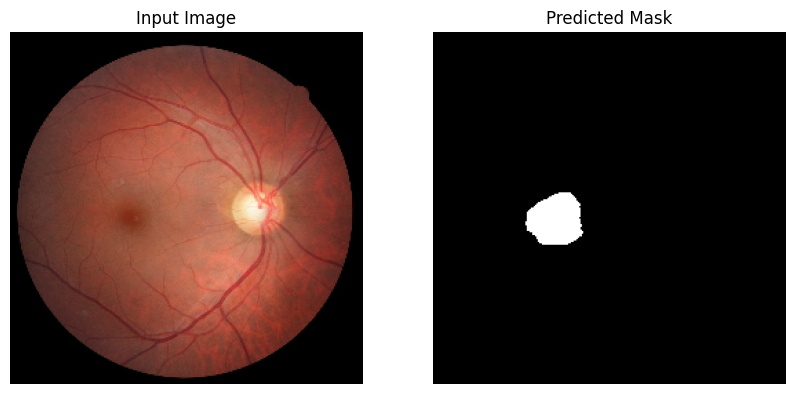

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Load the best U-Net model
model = tf.keras.models.load_model('best_unet_model.keras', custom_objects={'combined_loss': combined_loss})

def preprocess_image(image_path, img_size):
    """Preprocess the input image to the required size and scale."""
    img = load_img(image_path, target_size=img_size)
    img_gray = load_img(image_path, target_size=img_size, color_mode='grayscale')

    img = img_to_array(img) / 255.0  # Original color image for display
    img_gray = img_to_array(img_gray) / 255.0  # Grayscale image for prediction

    img_gray = np.expand_dims(img_gray, axis=0)  # Add batch dimension
    return img, img_gray

def postprocess_mask(predicted_mask):
    """Postprocess the predicted mask to convert it into binary format."""
    predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Convert to binary mask
    return predicted_mask

def display_image_and_mask(color_image, predicted_mask):
    """Display the input color image and its predicted mask."""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(color_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    plt.show()

# Path to the unseen image
unseen_image_path = '/content/drive/MyDrive/DR FUNDUS IMAGES FOR MASKS/IMAGE1.jpeg'  # replace with your image path

# Preprocess the unseen image
input_img_size = (256, 256)
color_image, unseen_image_gray = preprocess_image(unseen_image_path, input_img_size)

# Predict the mask for the unseen image
predicted_mask = model.predict(unseen_image_gray)

# Postprocess the predicted mask
predicted_mask = postprocess_mask(predicted_mask)

# Display the input image and its predicted mask
display_image_and_mask(color_image, predicted_mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


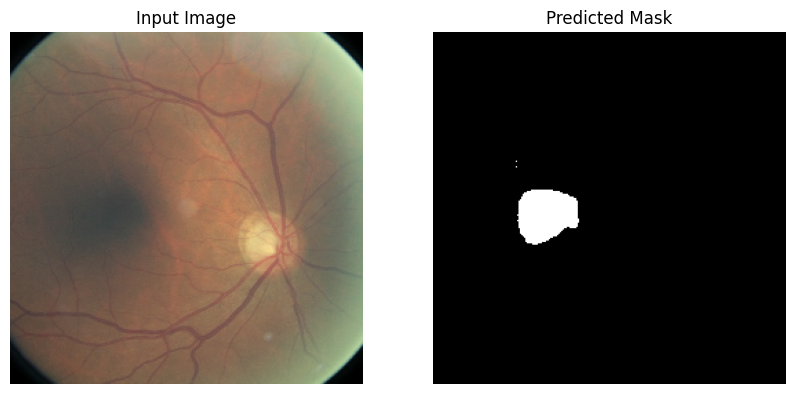

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Load the best U-Net model
model = tf.keras.models.load_model('best_unet_model.keras', custom_objects={'combined_loss': combined_loss})

def preprocess_image(image_path, img_size):
    """Preprocess the input image to the required size and scale."""
    img = load_img(image_path, target_size=img_size)
    img_gray = load_img(image_path, target_size=img_size, color_mode='grayscale')

    img = img_to_array(img) / 255.0  # Original color image for display
    img_gray = img_to_array(img_gray) / 255.0  # Grayscale image for prediction

    img_gray = np.expand_dims(img_gray, axis=0)  # Add batch dimension
    return img, img_gray

def postprocess_mask(predicted_mask):
    """Postprocess the predicted mask to convert it into binary format."""
    predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Convert to binary mask
    return predicted_mask

def display_image_and_mask(color_image, predicted_mask):
    """Display the input color image and its predicted mask."""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(color_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    plt.show()

# Path to the unseen image
unseen_image_path = '/content/drive/MyDrive/DR FUNDUS IMAGES FOR MASKS/IMAGE67.jpeg'  # replace with your image path

# Preprocess the unseen image
input_img_size = (256, 256)
color_image, unseen_image_gray = preprocess_image(unseen_image_path, input_img_size)

# Predict the mask for the unseen image
predicted_mask = model.predict(unseen_image_gray)

# Postprocess the predicted mask
predicted_mask = postprocess_mask(predicted_mask)

# Display the input image and its predicted mask
display_image_and_mask(color_image, predicted_mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


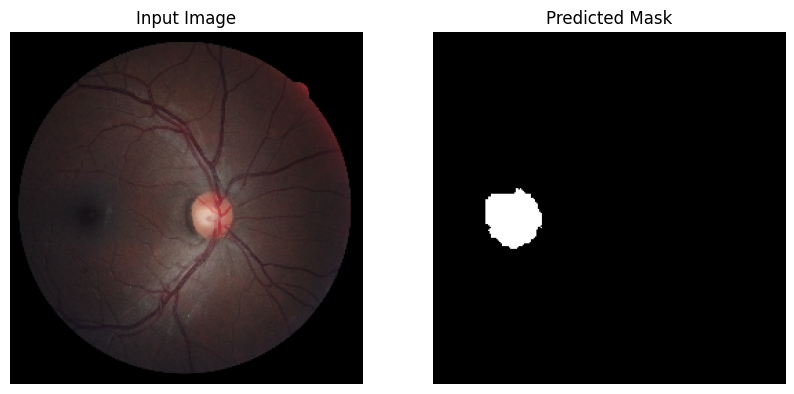

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Load the best U-Net model
model = tf.keras.models.load_model('best_unet_model.keras', custom_objects={'combined_loss': combined_loss})

def preprocess_image(image_path, img_size):
    """Preprocess the input image to the required size and scale."""
    img = load_img(image_path, target_size=img_size)
    img_gray = load_img(image_path, target_size=img_size, color_mode='grayscale')

    img = img_to_array(img) / 255.0  # Original color image for display
    img_gray = img_to_array(img_gray) / 255.0  # Grayscale image for prediction

    img_gray = np.expand_dims(img_gray, axis=0)  # Add batch dimension
    return img, img_gray

def postprocess_mask(predicted_mask):
    """Postprocess the predicted mask to convert it into binary format."""
    predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Convert to binary mask
    return predicted_mask

def display_image_and_mask(color_image, predicted_mask):
    """Display the input color image and its predicted mask."""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(color_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    plt.show()

# Path to the unseen image
unseen_image_path = '/content/drive/MyDrive/DR FUNDUS IMAGES FOR MASKS/IMAGE13.jpeg'  # replace with your image path

# Preprocess the unseen image
input_img_size = (256, 256)
color_image, unseen_image_gray = preprocess_image(unseen_image_path, input_img_size)

# Predict the mask for the unseen image
predicted_mask = model.predict(unseen_image_gray)

# Postprocess the predicted mask
predicted_mask = postprocess_mask(predicted_mask)

# Display the input image and its predicted mask
display_image_and_mask(color_image, predicted_mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


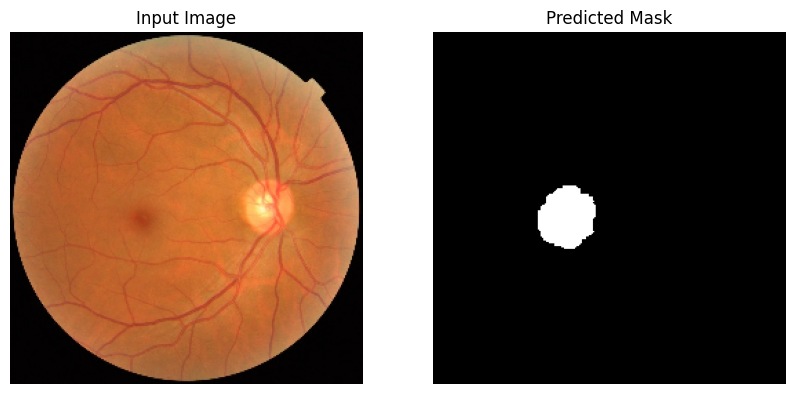

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Load the best U-Net model
model = tf.keras.models.load_model('best_unet_model.keras', custom_objects={'combined_loss': combined_loss})

def preprocess_image(image_path, img_size):
    """Preprocess the input image to the required size and scale."""
    img = load_img(image_path, target_size=img_size)
    img_gray = load_img(image_path, target_size=img_size, color_mode='grayscale')

    img = img_to_array(img) / 255.0  # Original color image for display
    img_gray = img_to_array(img_gray) / 255.0  # Grayscale image for prediction

    img_gray = np.expand_dims(img_gray, axis=0)  # Add batch dimension
    return img, img_gray

def postprocess_mask(predicted_mask):
    """Postprocess the predicted mask to convert it into binary format."""
    predicted_mask = np.squeeze(predicted_mask)  # Remove batch dimension
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Convert to binary mask
    return predicted_mask

def display_image_and_mask(color_image, predicted_mask):
    """Display the input color image and its predicted mask."""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(color_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    plt.show()

# Path to the unseen image
unseen_image_path = '/content/drive/MyDrive/DR FUNDUS IMAGES FOR MASKS/IMAGE11.jpeg'  # replace with your image path

# Preprocess the unseen image
input_img_size = (256, 256)
color_image, unseen_image_gray = preprocess_image(unseen_image_path, input_img_size)

# Predict the mask for the unseen image
predicted_mask = model.predict(unseen_image_gray)

# Postprocess the predicted mask
predicted_mask = postprocess_mask(predicted_mask)

# Display the input image and its predicted mask
display_image_and_mask(color_image, predicted_mask)
